In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import optuna
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn._oldcore')

In [2]:
df = pd.read_csv("Phishing_Legitimate_full.csv")

In [3]:
print(f"{df.dtypes}\n")
print(f"Dimension: {df.shape[0]} x {df.shape[1]}\n")

datatype_counts = df.dtypes.value_counts()
for dtype, count in datatype_counts.items():
    print(f"{dtype}: {count} columns")

id                                      int64
NumDots                                 int64
SubdomainLevel                          int64
PathLevel                               int64
UrlLength                               int64
NumDash                                 int64
NumDashInHostname                       int64
AtSymbol                                int64
TildeSymbol                             int64
NumUnderscore                           int64
NumPercent                              int64
NumQueryComponents                      int64
NumAmpersand                            int64
NumHash                                 int64
NumNumericChars                         int64
NoHttps                                 int64
RandomString                            int64
IpAddress                               int64
DomainInSubdomains                      int64
DomainInPaths                           int64
HttpsInHostname                         int64
HostnameLength                    

In [4]:
df = df.drop("id", axis=1)

In [5]:
null = df.isnull().sum()
for i in range(len(df.columns)):
    print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")
total_cells = np.prod(df.shape)
total_missing = null.sum()
print(f"\nTotal missing values: {total_missing} ({(total_missing/total_cells) * 100}%)\n")

NumDots: 0 (0.0%)
SubdomainLevel: 0 (0.0%)
PathLevel: 0 (0.0%)
UrlLength: 0 (0.0%)
NumDash: 0 (0.0%)
NumDashInHostname: 0 (0.0%)
AtSymbol: 0 (0.0%)
TildeSymbol: 0 (0.0%)
NumUnderscore: 0 (0.0%)
NumPercent: 0 (0.0%)
NumQueryComponents: 0 (0.0%)
NumAmpersand: 0 (0.0%)
NumHash: 0 (0.0%)
NumNumericChars: 0 (0.0%)
NoHttps: 0 (0.0%)
RandomString: 0 (0.0%)
IpAddress: 0 (0.0%)
DomainInSubdomains: 0 (0.0%)
DomainInPaths: 0 (0.0%)
HttpsInHostname: 0 (0.0%)
HostnameLength: 0 (0.0%)
PathLength: 0 (0.0%)
QueryLength: 0 (0.0%)
DoubleSlashInPath: 0 (0.0%)
NumSensitiveWords: 0 (0.0%)
EmbeddedBrandName: 0 (0.0%)
PctExtHyperlinks: 0 (0.0%)
PctExtResourceUrls: 0 (0.0%)
ExtFavicon: 0 (0.0%)
InsecureForms: 0 (0.0%)
RelativeFormAction: 0 (0.0%)
ExtFormAction: 0 (0.0%)
AbnormalFormAction: 0 (0.0%)
PctNullSelfRedirectHyperlinks: 0 (0.0%)
FrequentDomainNameMismatch: 0 (0.0%)
FakeLinkInStatusBar: 0 (0.0%)
RightClickDisabled: 0 (0.0%)
PopUpWindow: 0 (0.0%)
SubmitInfoToEmail: 0 (0.0%)
IframeOrFrame: 0 (0.0%)
Miss

/tmp/ipykernel_18/1295806530.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")


<font size="+1">The data is clear of nulls, we got 0 nulls for all columns!. Next we will check for outliers in the data.</font>

In [6]:
def is_continuous(series):
    return series.nunique() > 10

continuous_columns = [col for col in df.columns if is_continuous(df[col])]

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


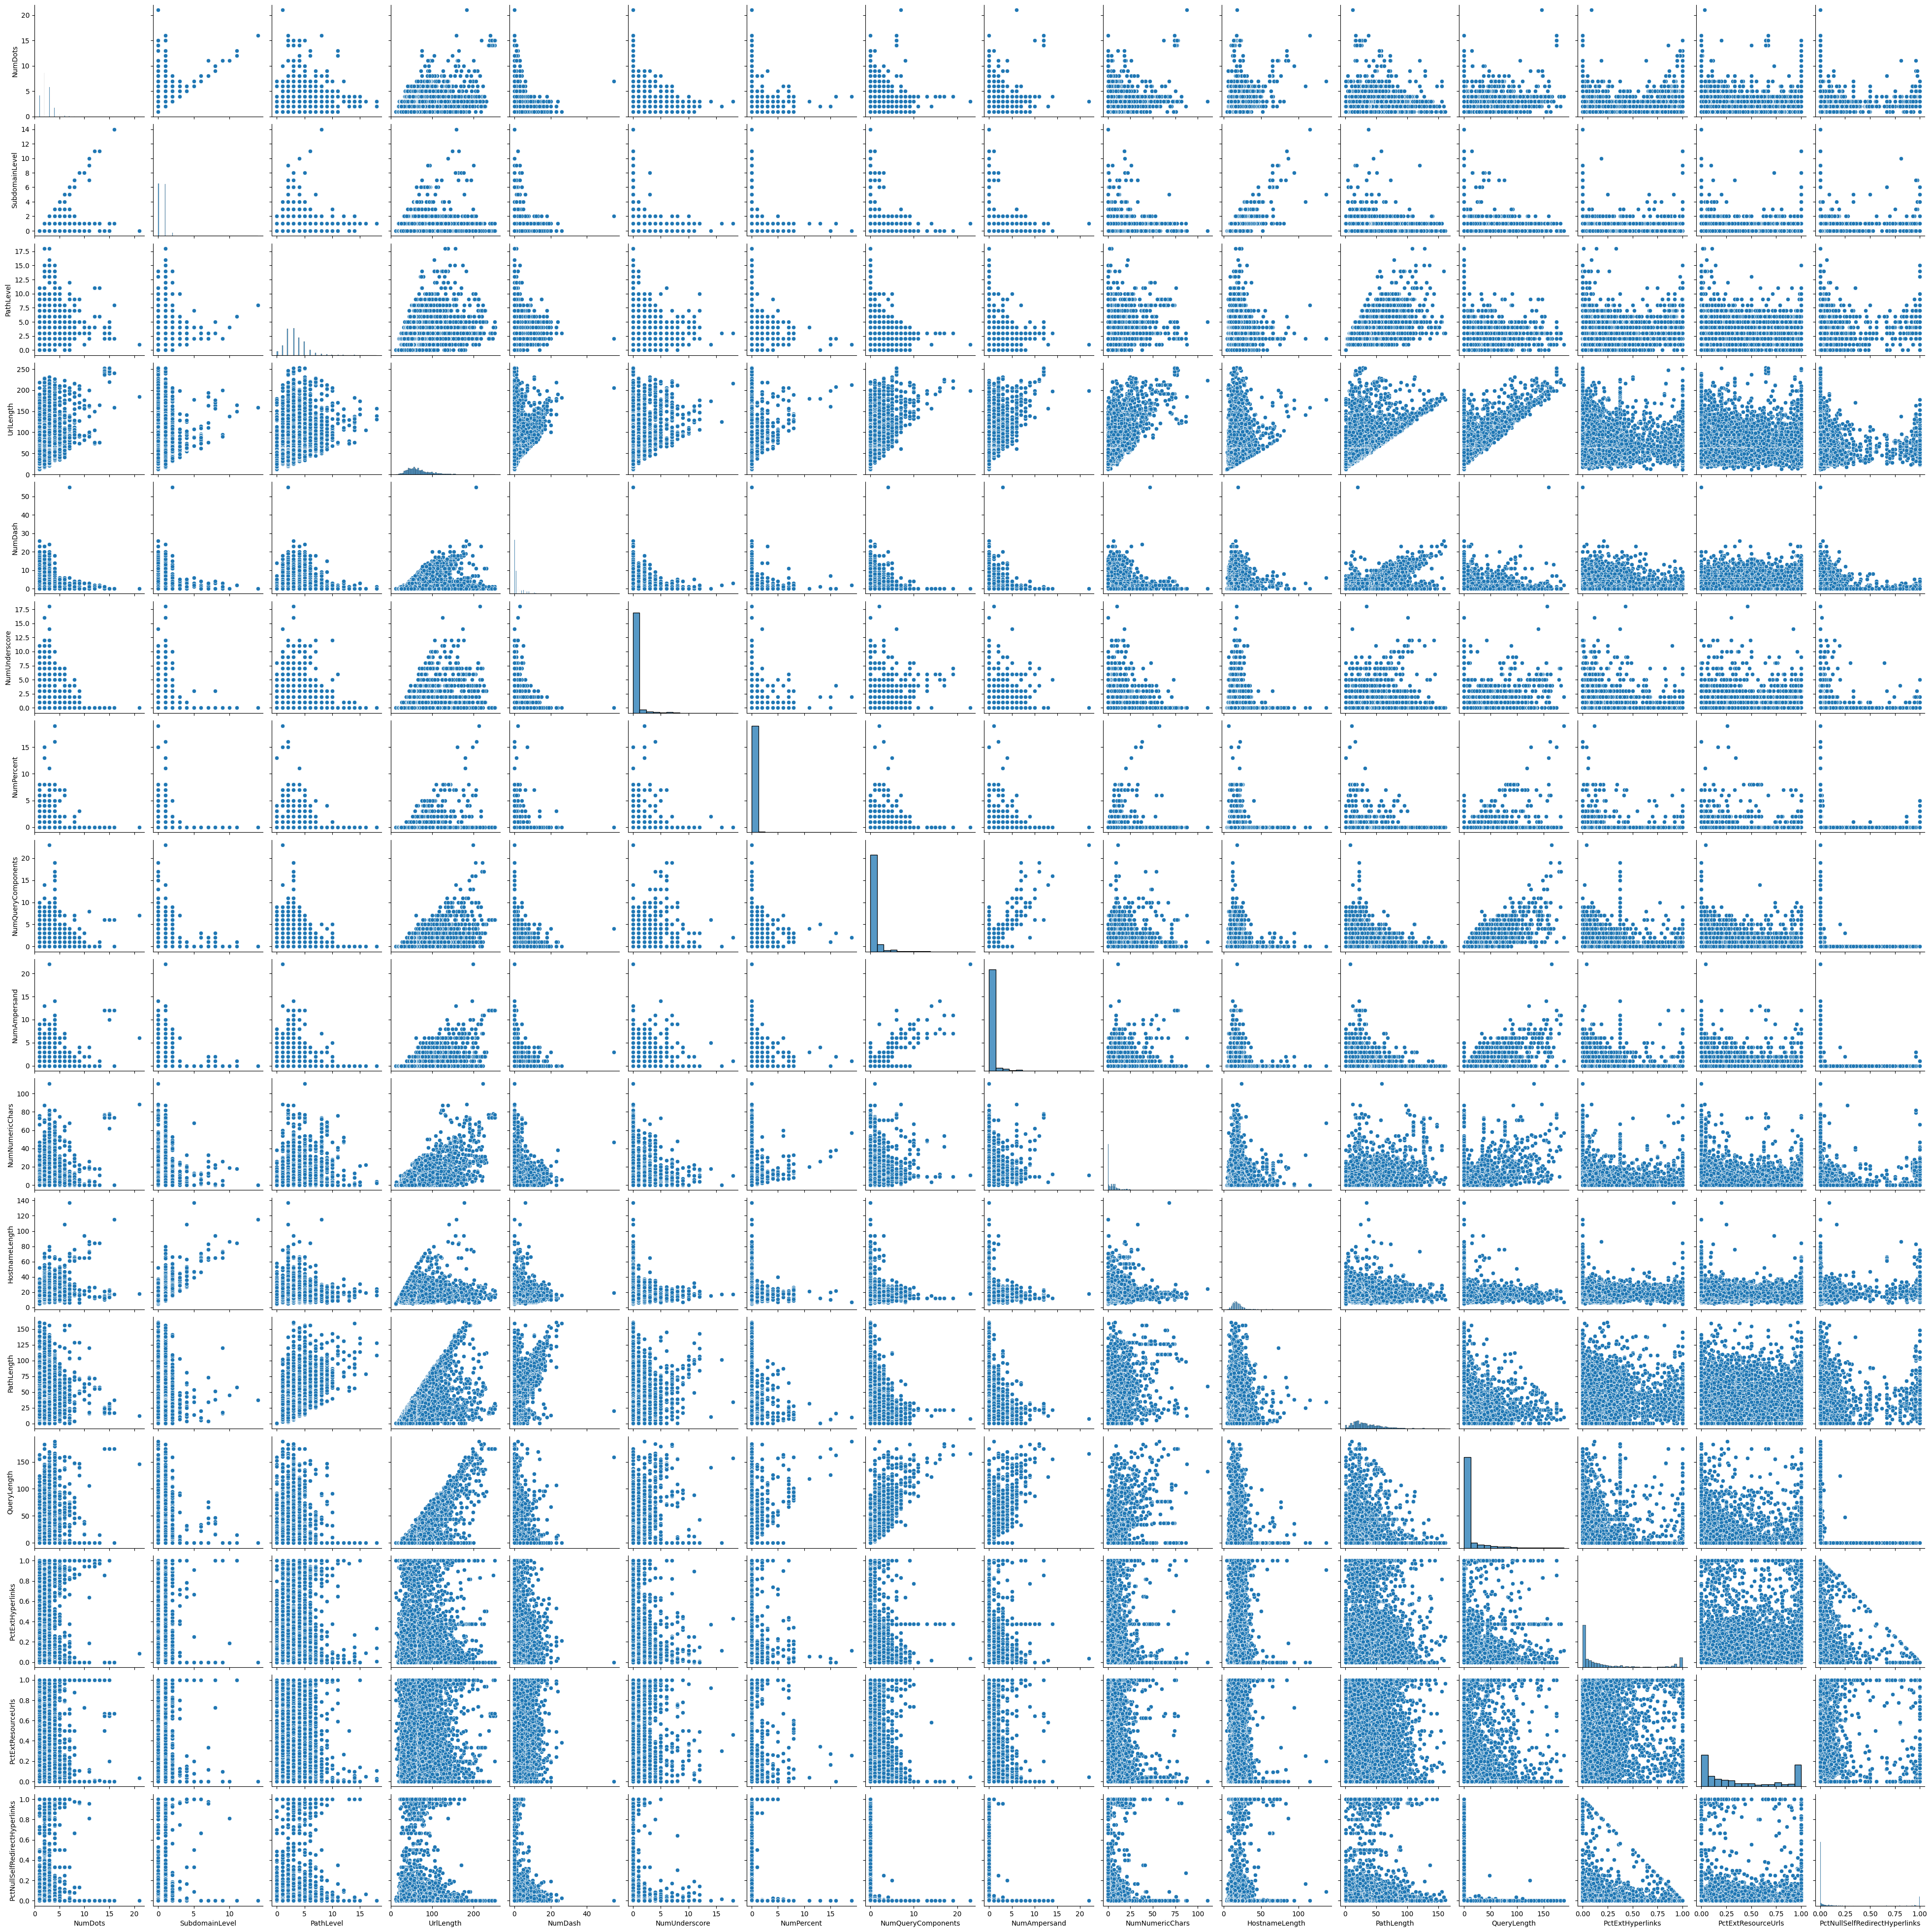

In [7]:
sns.pairplot(df[continuous_columns], size = 2.5)
plt.show()

<font size="+1">Wow, this plot gave us insight about how the data shaped!, as you can see there are borders in shape such as triangle and square. There are also outliers which we will remove:</font>

<ul>
    <li><font size="+1">NumDash > 40</font></li>
    <li><font size="+1">NumDots > 20</font></li>
</ul>

<font size="+1">Let's see the correlation of our data.</font>

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


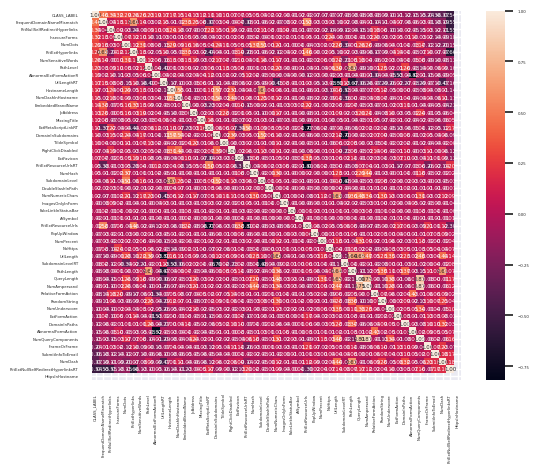

In [8]:
corr = df.corr()
cols = corr.nlargest(50, 'CLASS_LABEL')['CLASS_LABEL'].index
cm = np.corrcoef(df[cols].values.T)
sns.set_theme(font_scale=0.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 4}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
ordinal_columns = [col for col in df.columns if col not in continuous_columns]

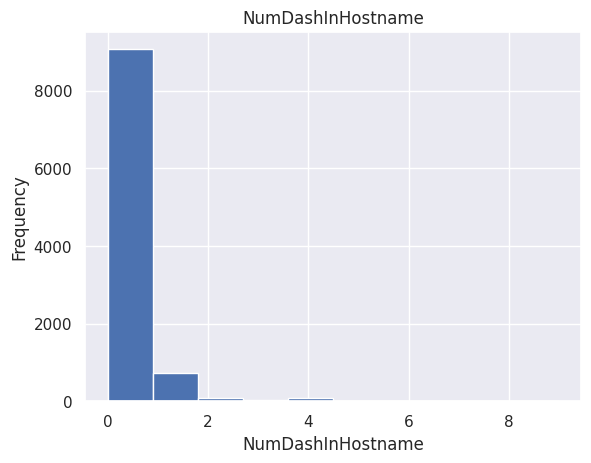

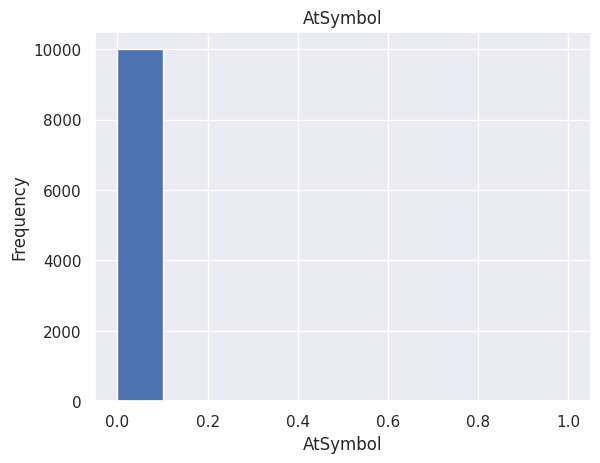

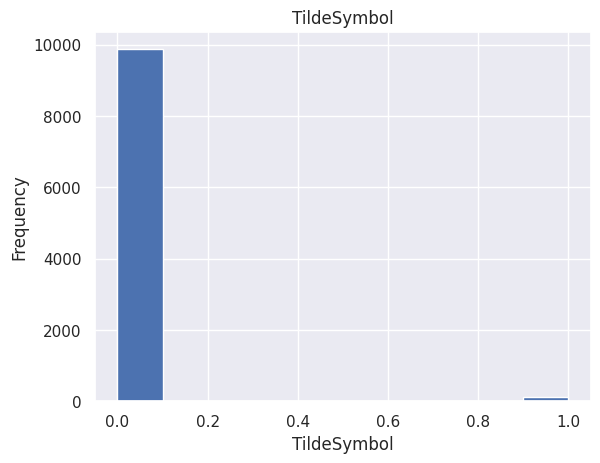

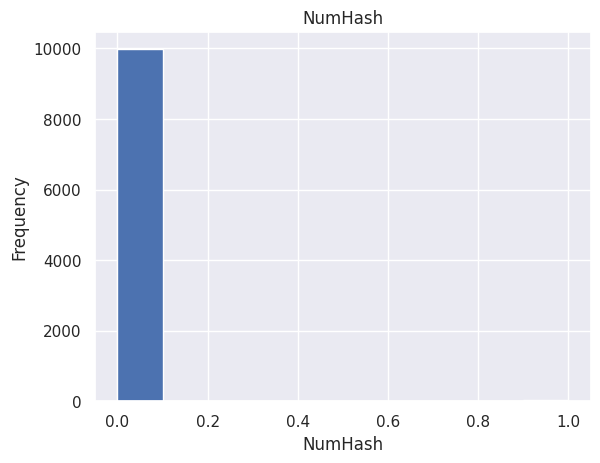

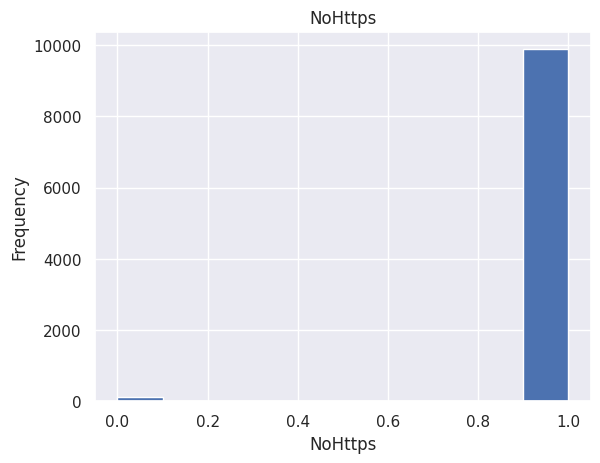

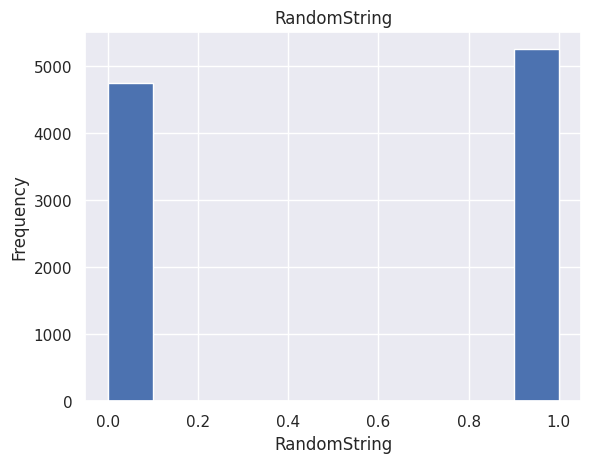

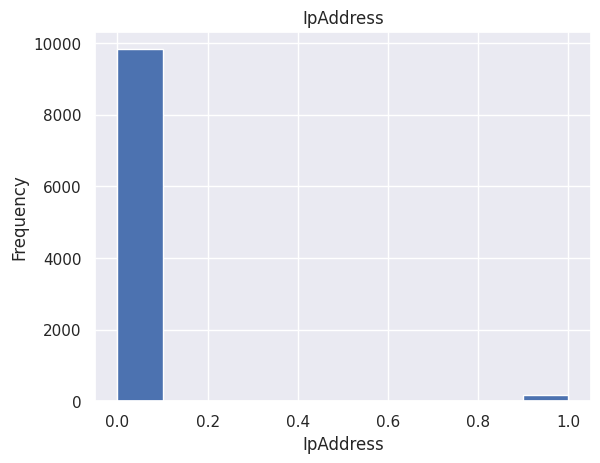

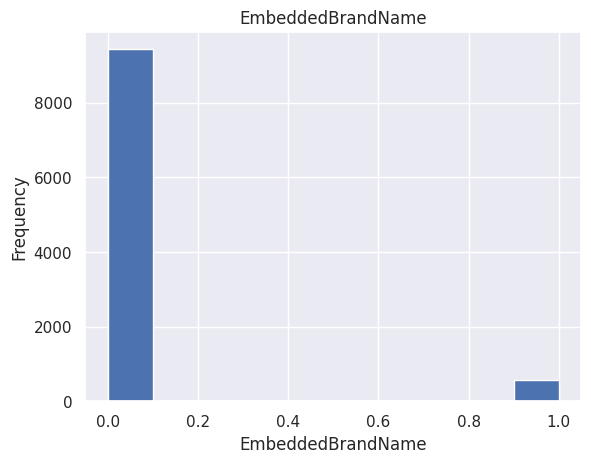

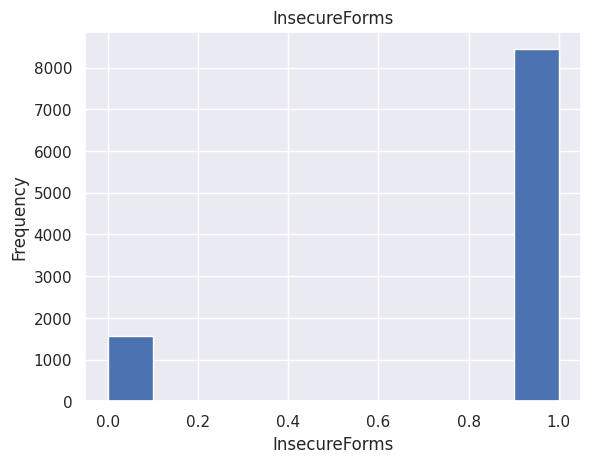

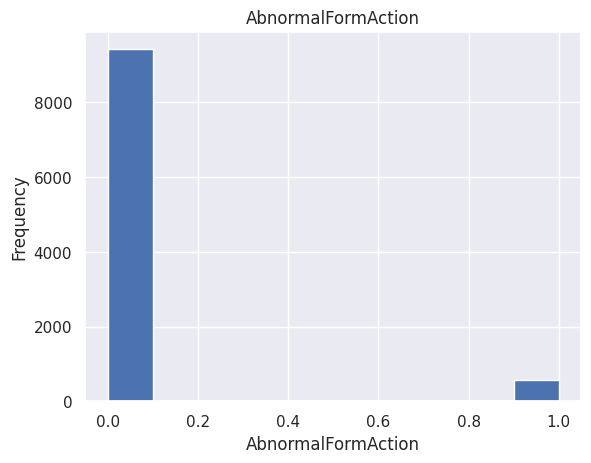

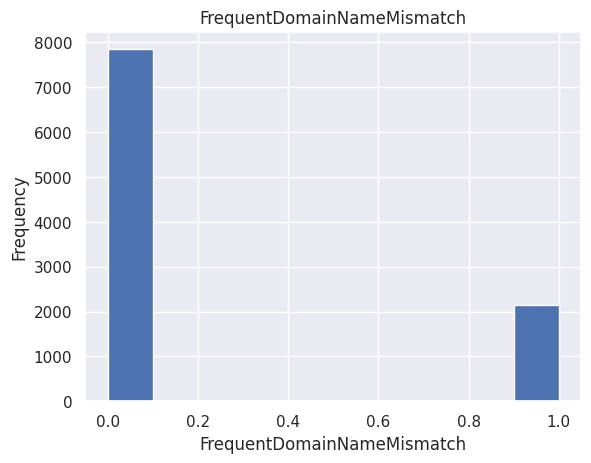

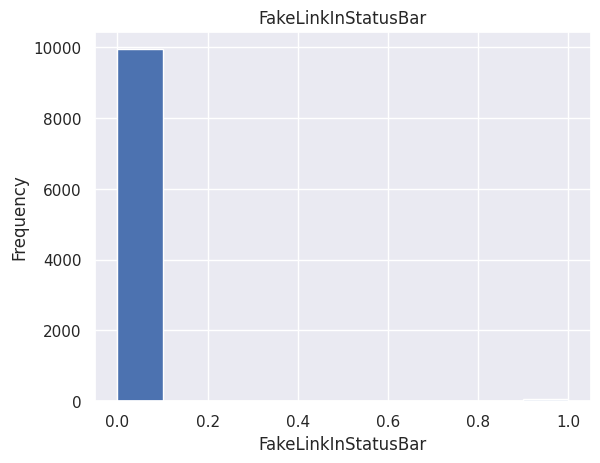

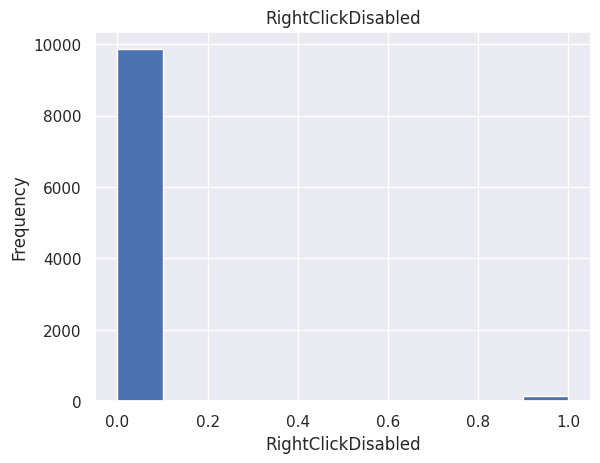

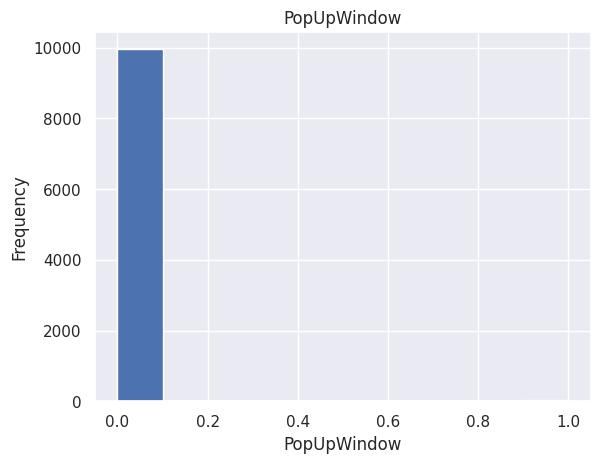

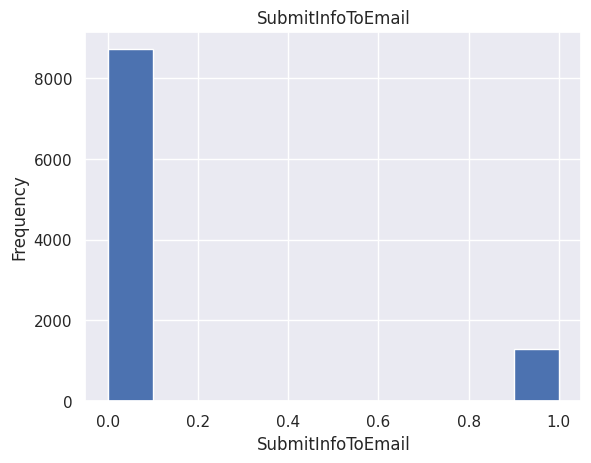

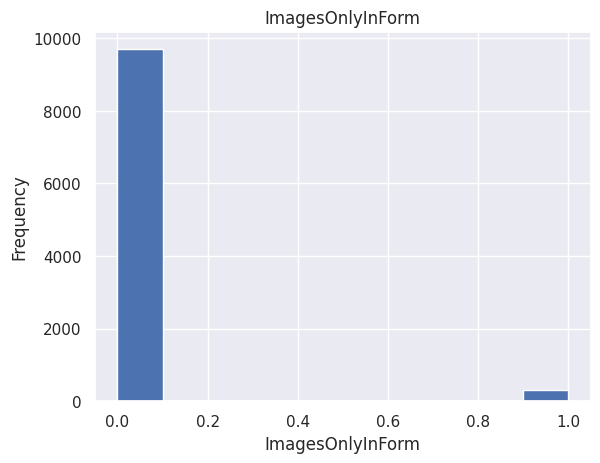

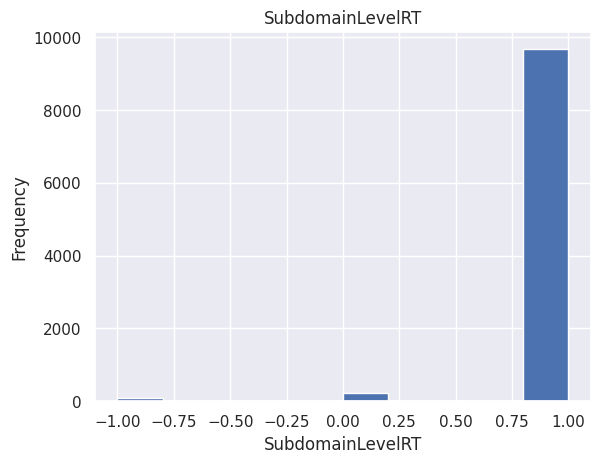

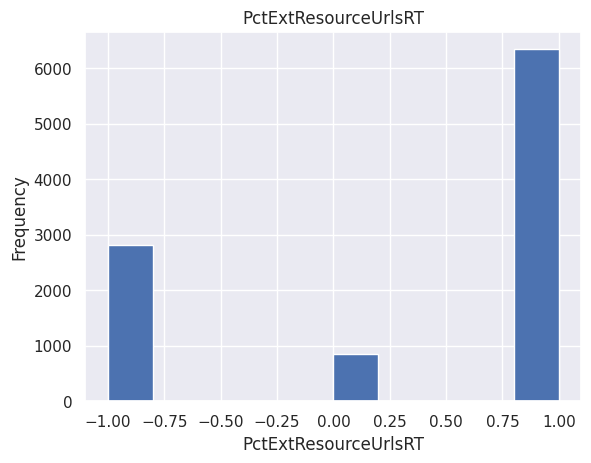

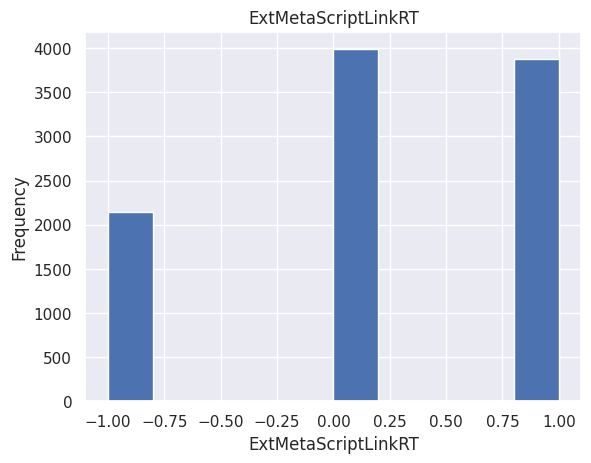

In [10]:
sns.set_theme(font_scale=1)
for col in ordinal_columns:
    plt.hist(df[col], bins=10)  
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col}')
    plt.show()

<font size="+1">All ordinal data seems in good range, we can continue checking the distribution of the continuous data</font>

In [11]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

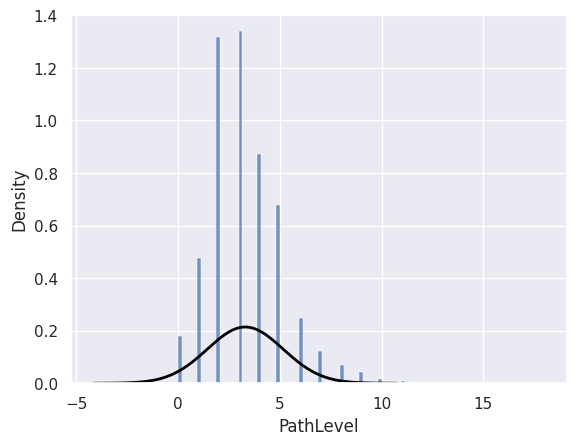

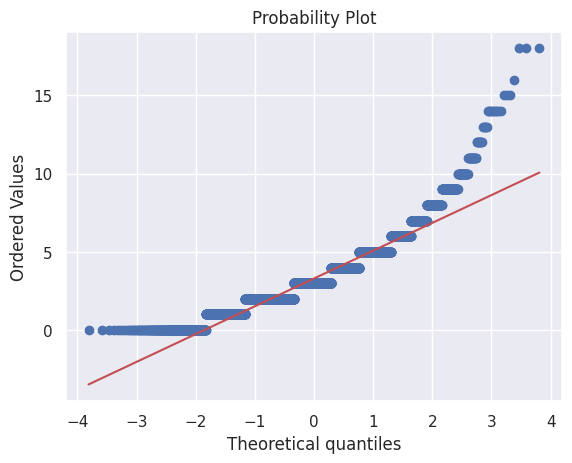

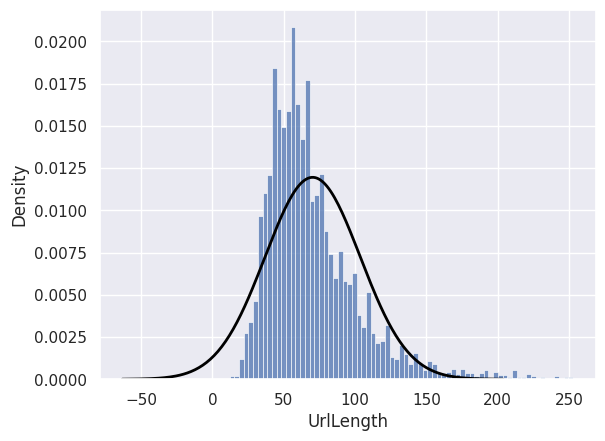

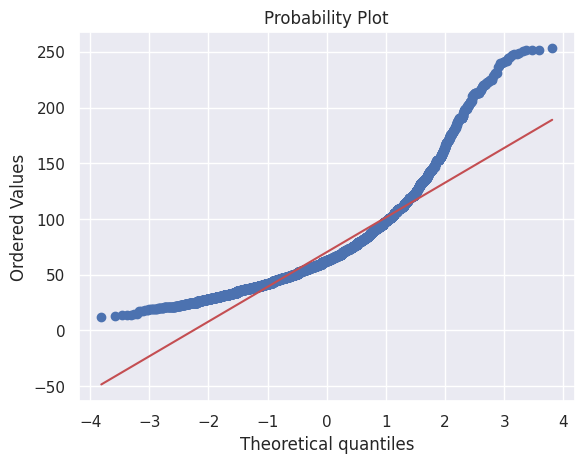

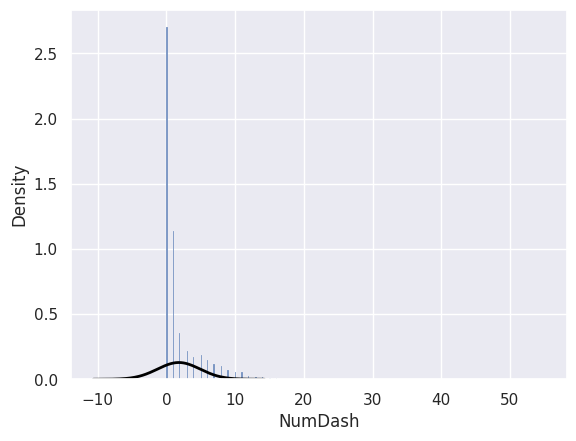

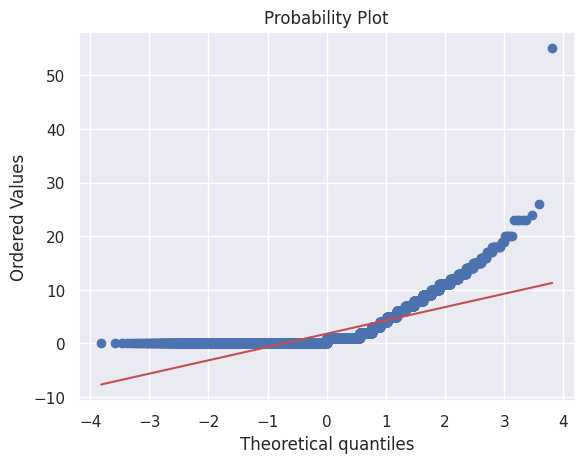

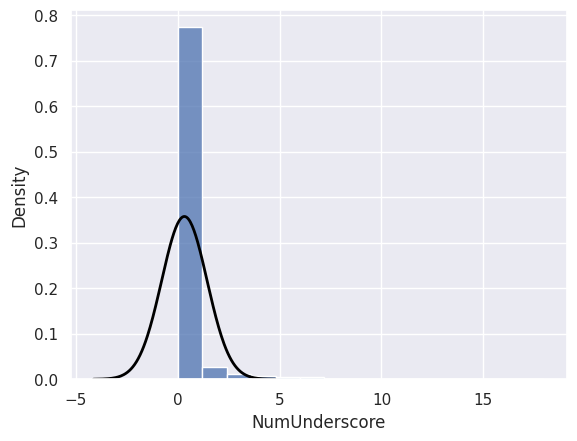

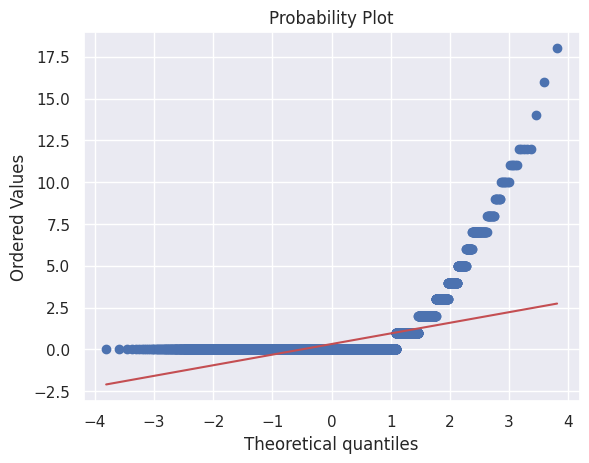

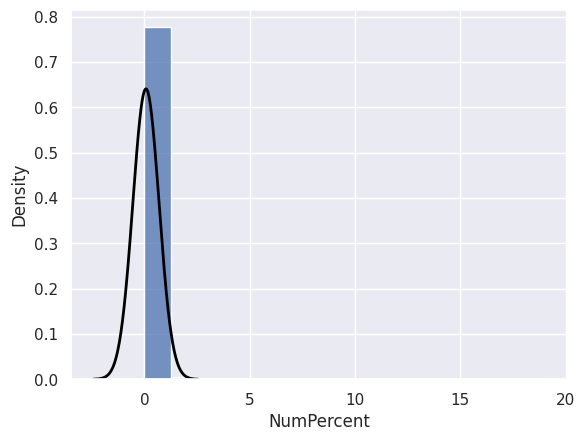

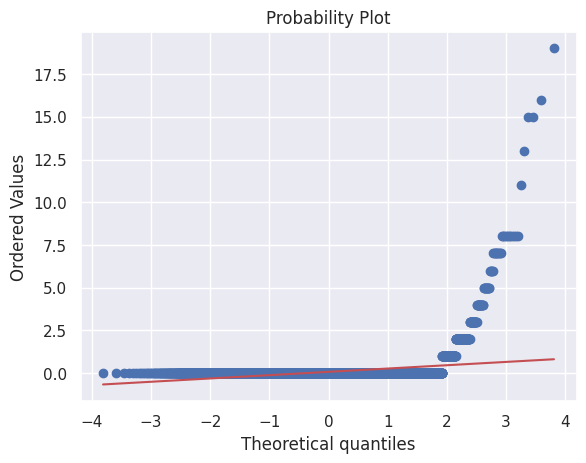

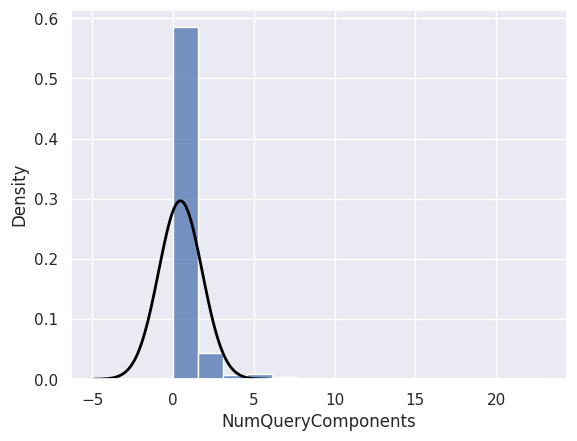

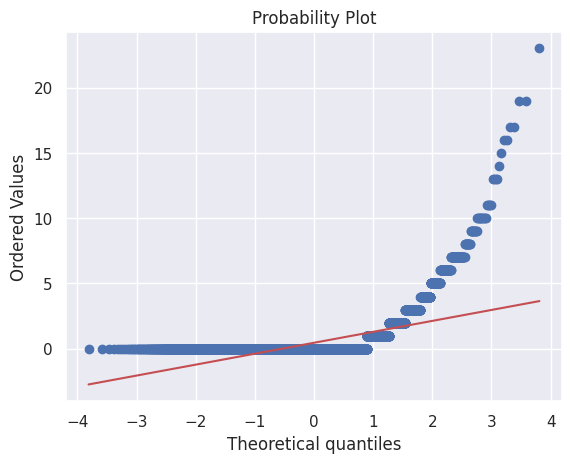

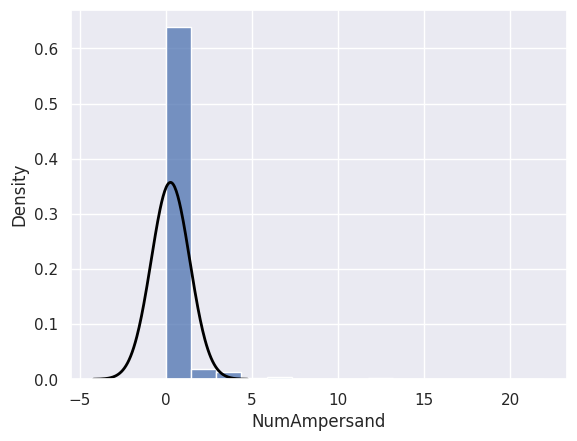

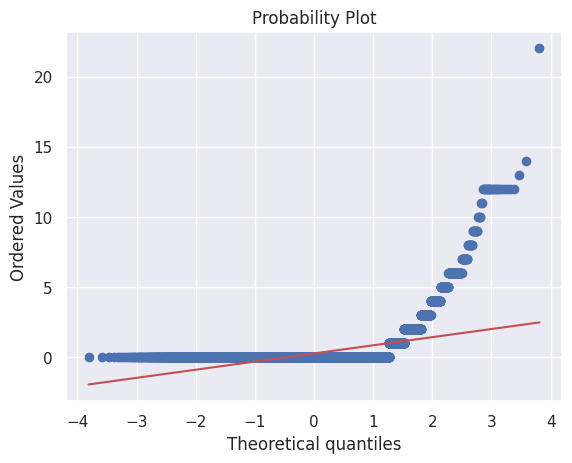

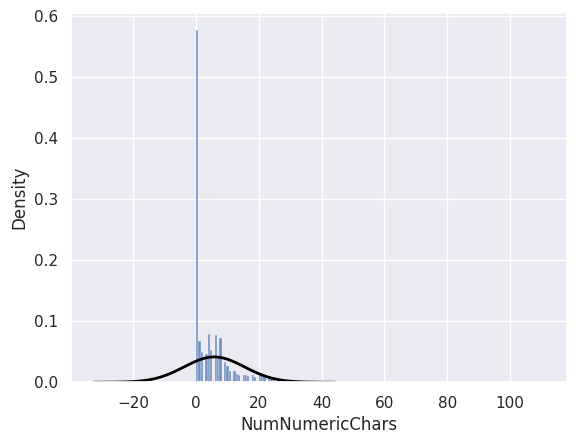

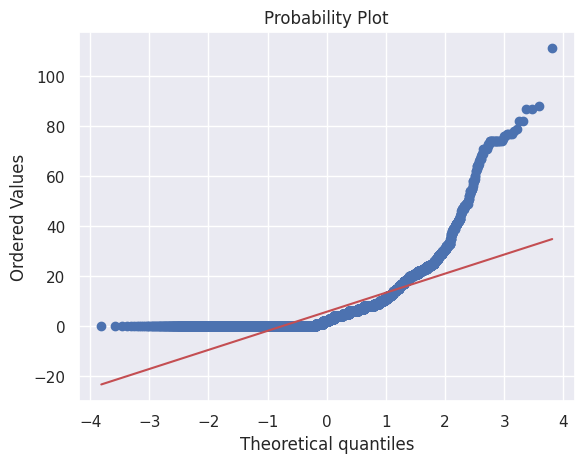

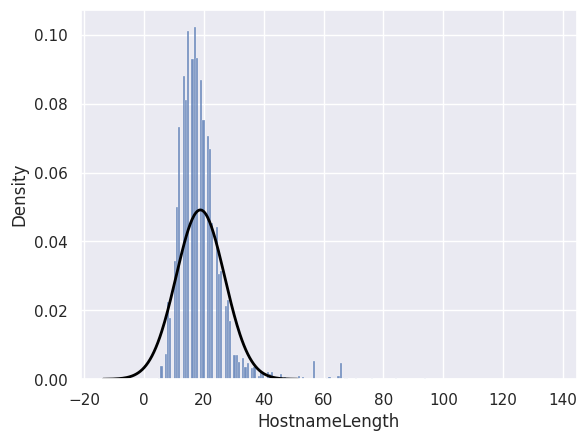

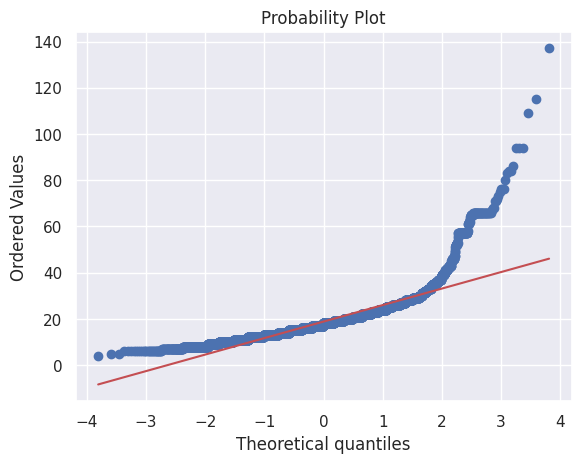

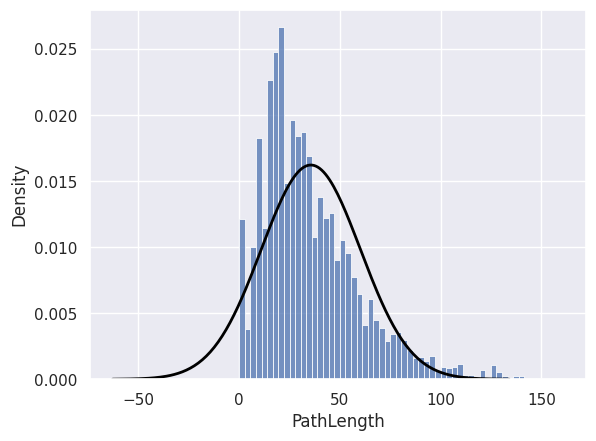

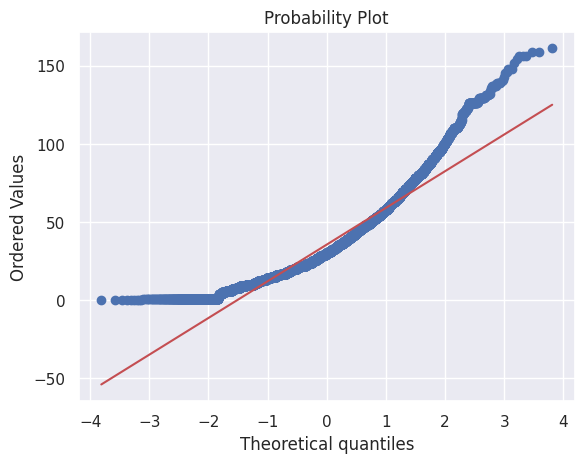

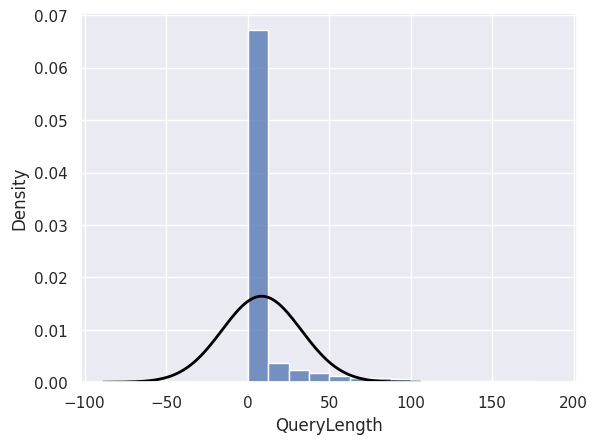

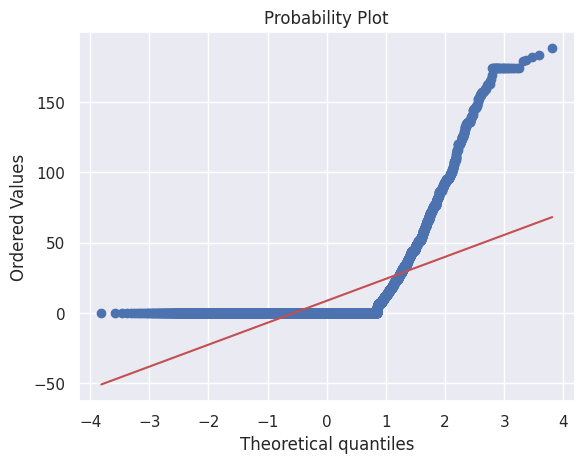

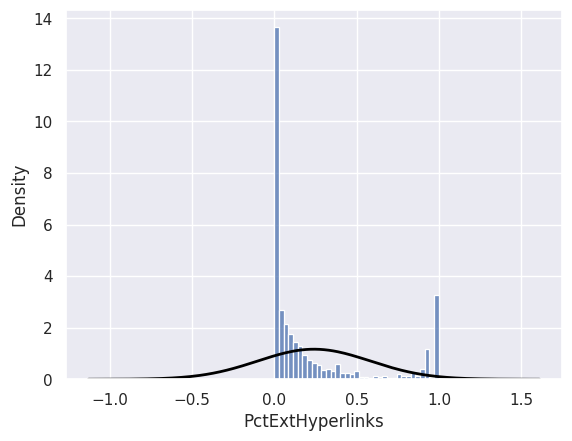

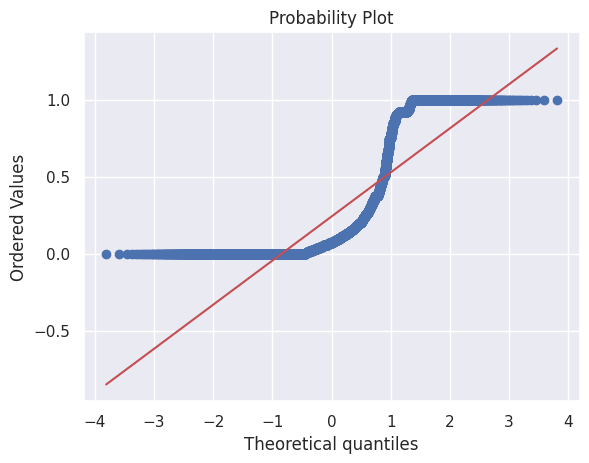

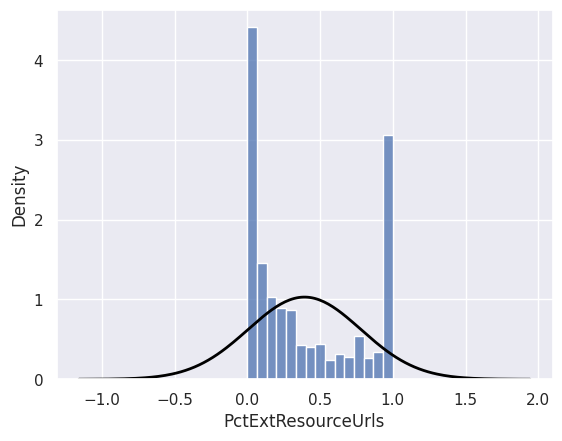

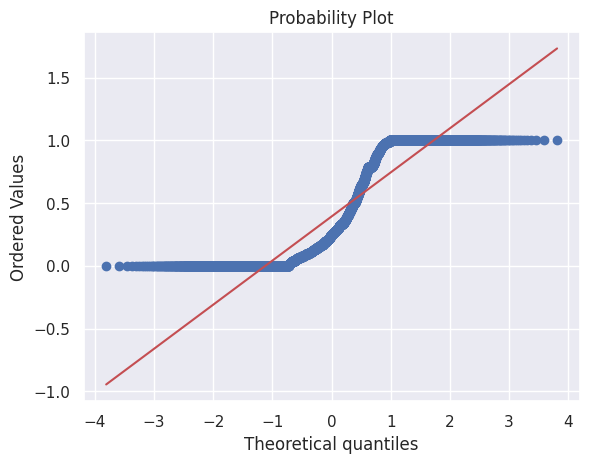

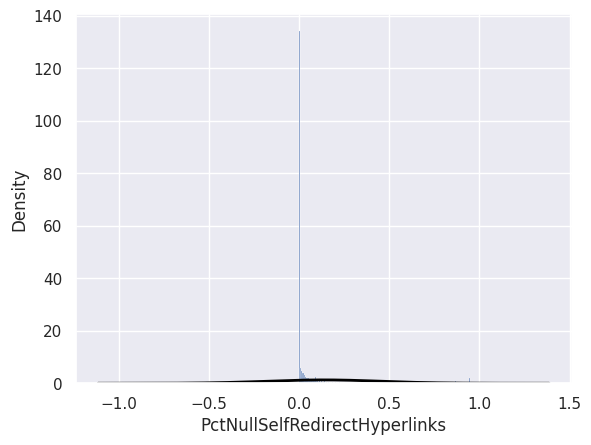

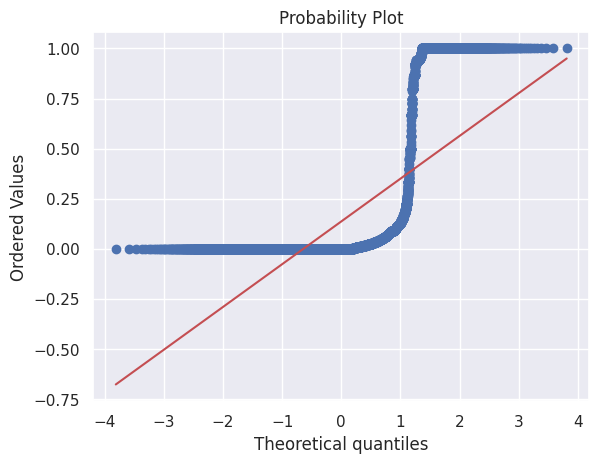

In [12]:
for col_name in continuous_columns:
    fig1, ax1 = plt.subplots()
    sns.histplot(x=df[col_name], stat="density", ax=ax1)
    normal(df[col_name].mean(), df[col_name].std())
    
    fig2, ax2 = plt.subplots()
    stats.probplot(df[col_name], plot=ax2)
    
    plt.show()

In [13]:
df = df[df['NumDots'] < 20]
df = df[df['NumDash'] < 40]

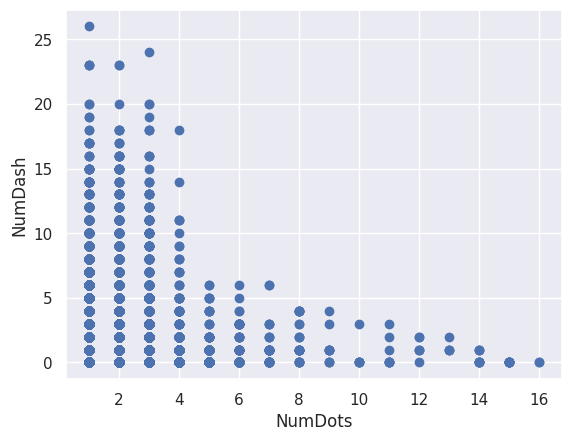

In [14]:
plt.scatter(x=df['NumDots'], y=df['NumDash'])
plt.xlabel('NumDots')
plt.ylabel('NumDash')
plt.show()

In [15]:
for col in continuous_columns:
    df[col], _ = yeojohnson(df[col]) 

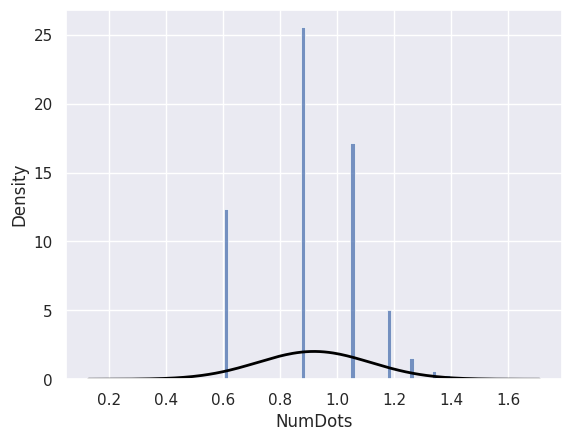

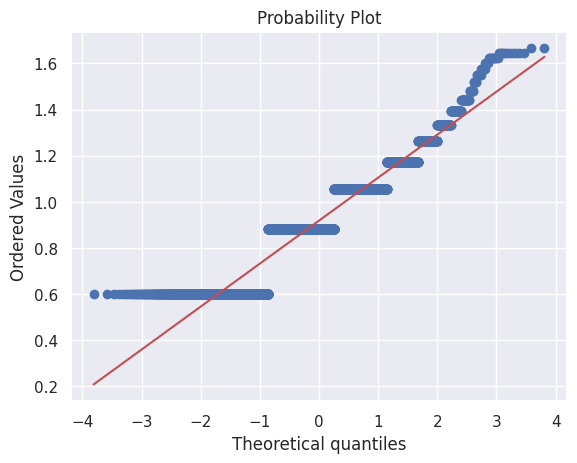

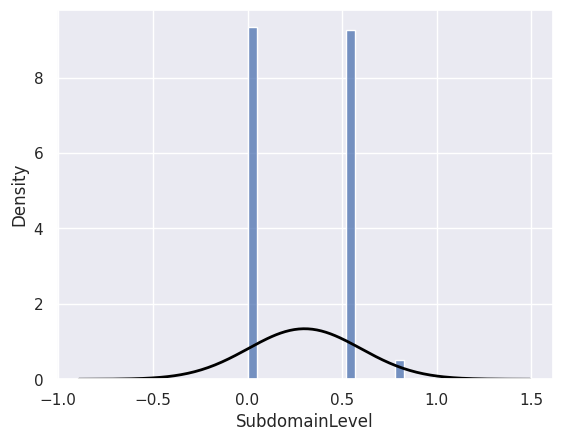

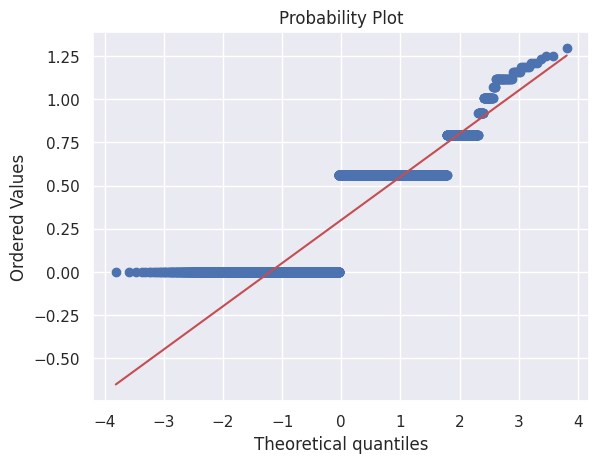

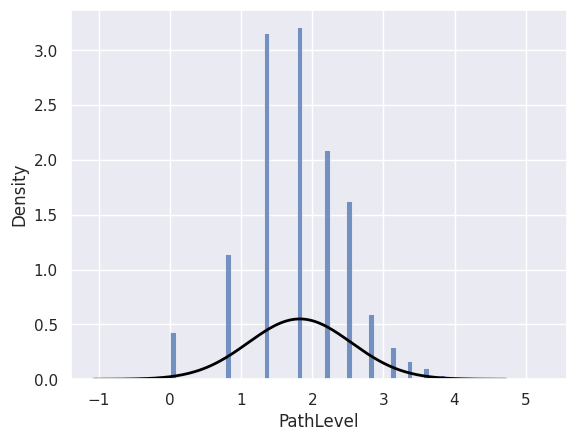

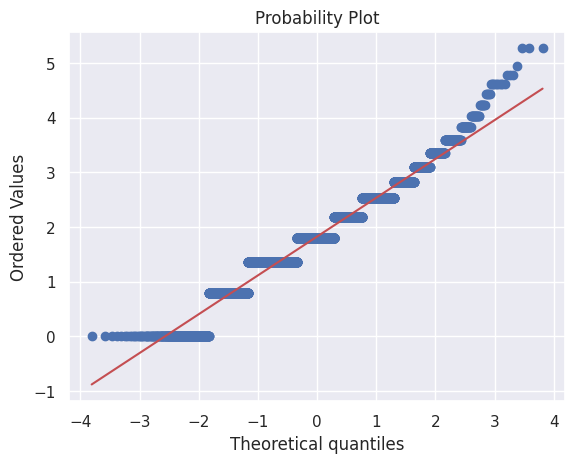

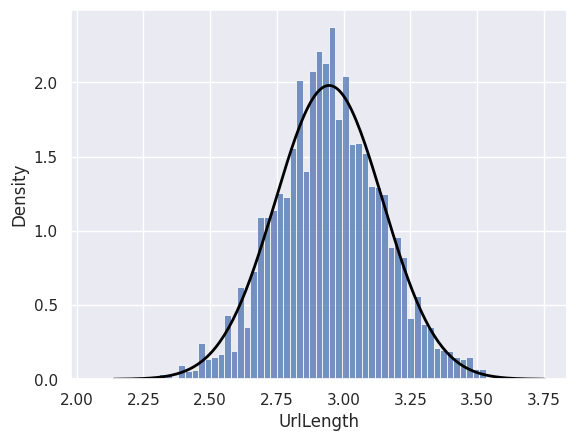

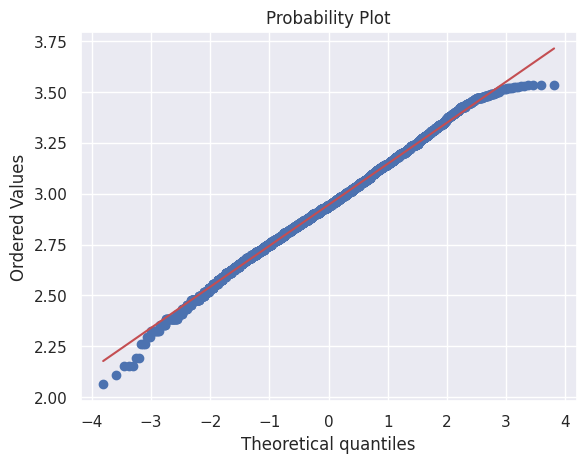

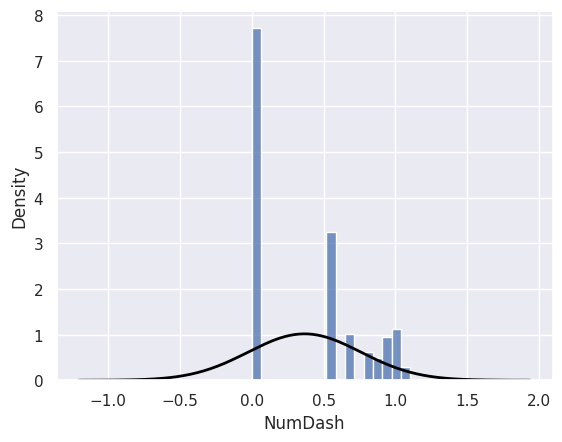

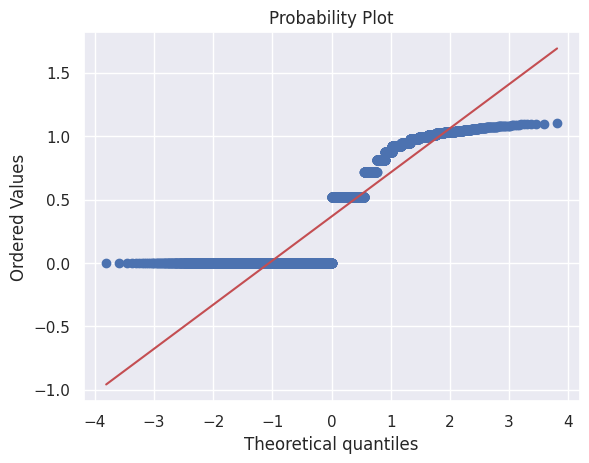

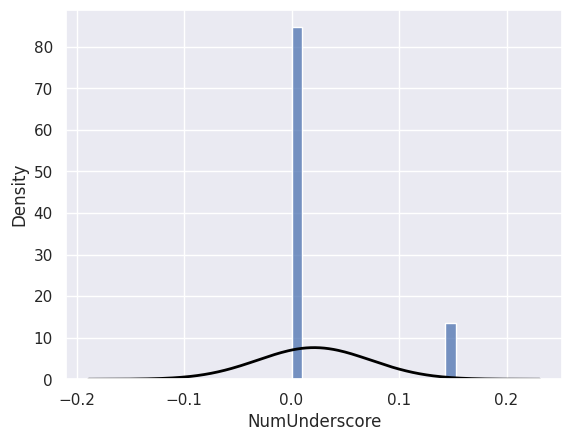

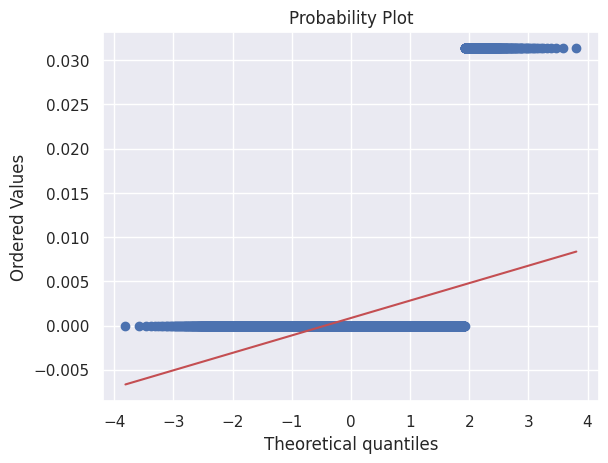

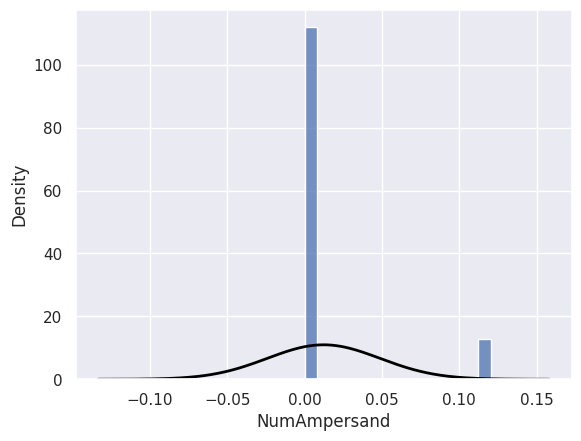

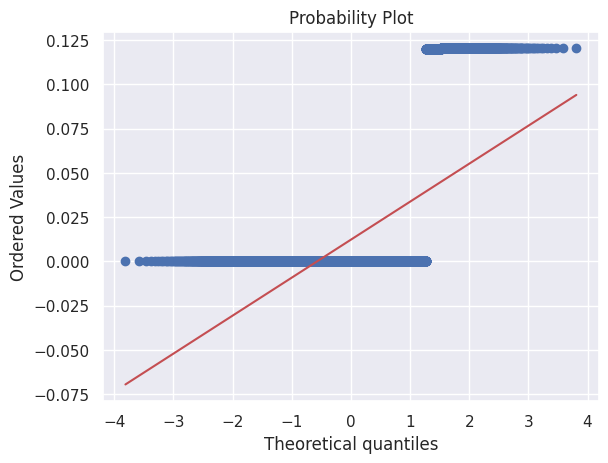

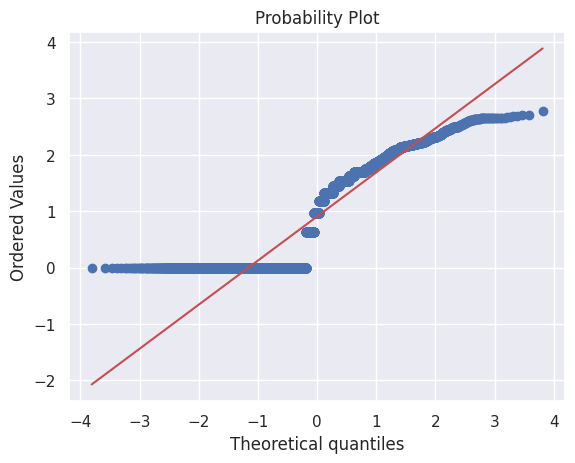

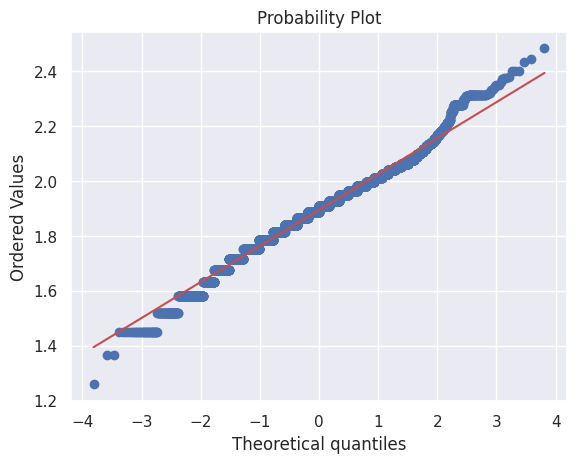

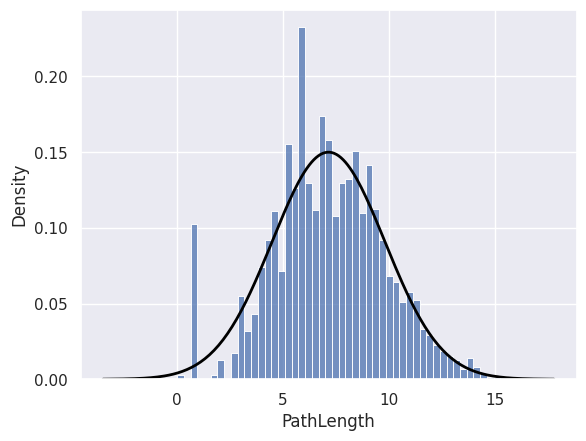

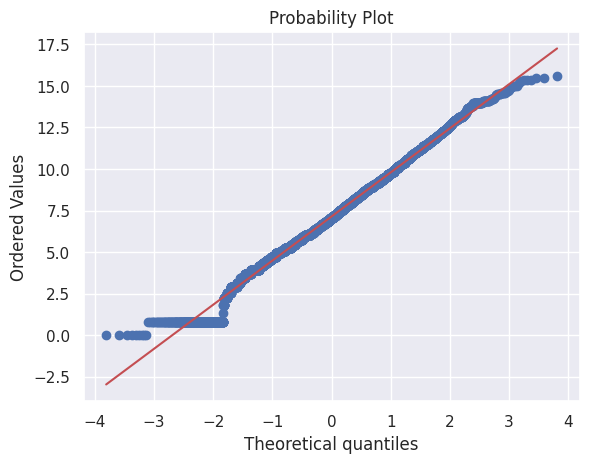

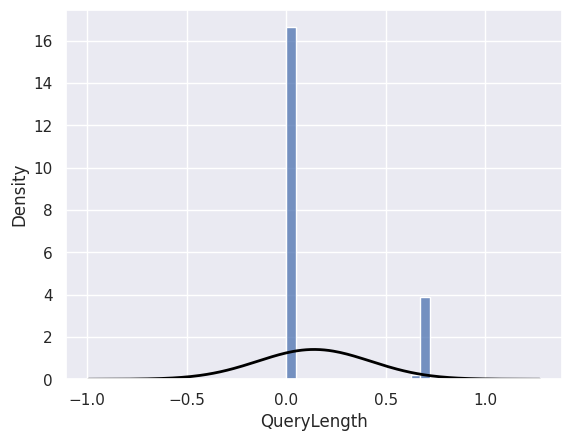

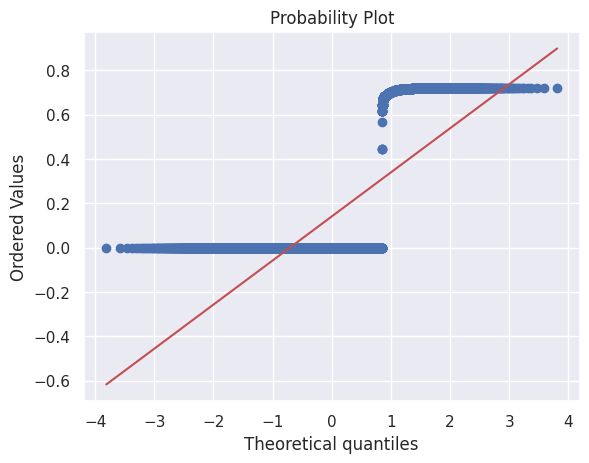

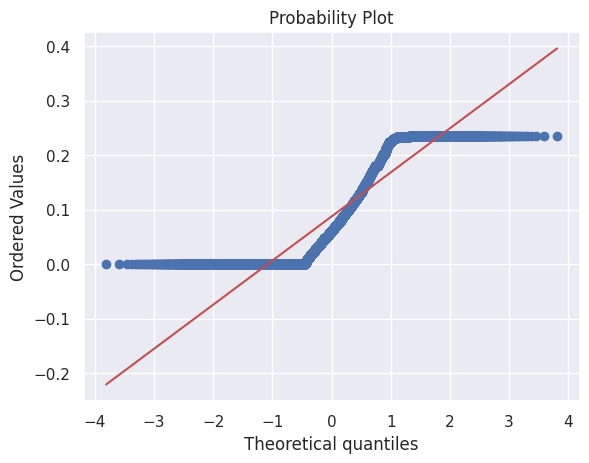

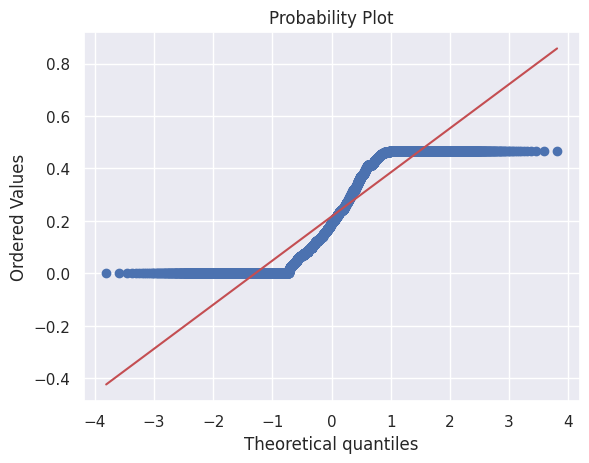

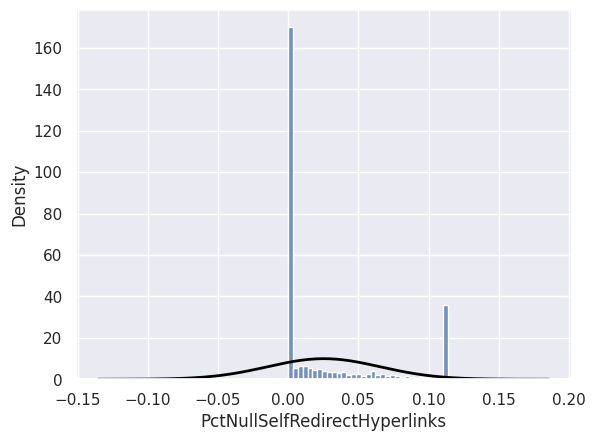

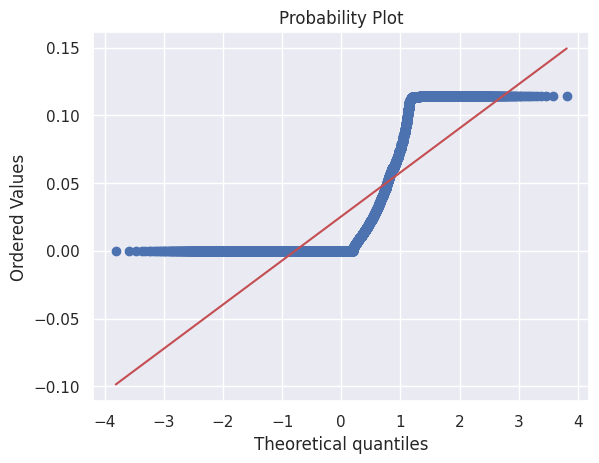

In [16]:
for col_name in continuous_columns:
    fig1, ax1 = plt.subplots()
    sns.histplot(x=df[col_name], stat="density", ax=ax1)
    normal(df[col_name].mean(), df[col_name].std())
    
    fig2, ax2 = plt.subplots()
    stats.probplot(df[col_name], plot=ax2)
    
    plt.show()

In [17]:
cols = df.columns.to_list()
cols.remove('CLASS_LABEL')

X = df[cols]
y = df["CLASS_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
results = best_trial.params

[I 2024-06-13 04:22:56,055] A new study created in memory with name: no-name-894a4f72-175f-4baa-a5c8-fa320d04dd4c
[I 2024-06-13 04:22:57,452] Trial 0 finished with value: 0.9745 and parameters: {'n_estimators': 261, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.9745.
[I 2024-06-13 04:22:58,129] Trial 1 finished with value: 0.9785 and parameters: {'n_estimators': 125, 'max_depth': 26, 'min_samples_split': 17, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.9785.
[I 2024-06-13 04:22:58,644] Trial 2 finished with value: 0.9745 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.9785.
[I 2024-06-13 04:22:59,637] Trial 3 finished with value: 0.9675 and parameters: {'n_estimators': 222, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9785.
[I 2024-06-13 04:22:59,866] Trial 4 finished with value: 0.9765 and p

In [19]:
model = RandomForestClassifier(n_estimators=results['n_estimators'], max_depth=results['max_depth'], min_samples_split=results['min_samples_split'], min_samples_leaf=results['min_samples_leaf'], random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, min_samples_split=6, n_estimators=142,
                       n_jobs=-1, random_state=42)

<font size="+1">Lastly, we will check the model performance</font>

In [20]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

